In [1]:
import os
import random
from pathlib import Path
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, applications
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd

2025-10-10 23:16:03.518452: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760138163.711132      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760138163.776331      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Paths
input_root = "/kaggle/input/cxr-ct-cough/processed_dataset/processed_dataset"
output_root = "/kaggle/working/processed_dataset_split"
splits = {'train': 400, 'valid': 50, 'test': 50}
modalities = ["CT", "CXR", "Cough sound"]
classes = ["Healthy", "LungsCancer", "Pneumonia", "covid"]

In [3]:
print(" Creating dataset splits...")

# Create directories
for split in splits:
    for modality in modalities:
        for cls in classes:
            os.makedirs(os.path.join(output_root, split, modality, cls), exist_ok=True)

# Split images
for modality in modalities:
    for cls in classes:
        input_folder = os.path.join(input_root, modality, cls)
        all_images = list(Path(input_folder).glob("*.[jp][pn]g"))
        
        if len(all_images) < 500:
            print(f" Not enough images in {modality}/{cls}")
            continue
        
        random.shuffle(all_images)
        split_images = {
            'train': all_images[:400],
            'valid': all_images[400:450],
            'test': all_images[450:500]
        }
        
        for split, img_paths in split_images.items():
            for idx, img_path in enumerate(img_paths, 1):
                img = Image.open(img_path).convert("RGB")
                new_name = f"{cls}{idx}.jpg"
                save_path = os.path.join(output_root, split, modality, cls, new_name)
                img.save(save_path)

print(" Dataset splits created!")

 Creating dataset splits...
 Dataset splits created!


In [4]:
def create_multimodal_dataset(split, batch_size=16):
    """
    Creates a dataset that loads CT, CXR, and Cough images together
    Returns:
        dataset with format: ((ct_batch, cxr_batch, cough_batch), labels_batch)
    """
    print(f" Loading {split} data...")
    
    # Collect all image paths and labels
    ct_paths = []
    cxr_paths = []
    cough_paths = []
    labels = []
    
    for class_idx, cls in enumerate(classes):
        for i in range(1, splits[split] + 1):
            ct_path = os.path.join(output_root, split, "CT", cls, f"{cls}{i}.jpg")
            cxr_path = os.path.join(output_root, split, "CXR", cls, f"{cls}{i}.jpg")
            cough_path = os.path.join(output_root, split, "Cough sound", cls, f"{cls}{i}.jpg")
            
            if os.path.exists(ct_path) and os.path.exists(cxr_path) and os.path.exists(cough_path):
                ct_paths.append(ct_path)
                cxr_paths.append(cxr_path)
                cough_paths.append(cough_path)
                labels.append(class_idx)
    
    print(f"   Found {len(labels)} complete triplets")
    
    # Convert to numpy arrays
    ct_paths = np.array(ct_paths)
    cxr_paths = np.array(cxr_paths)
    cough_paths = np.array(cough_paths)
    labels = np.array(labels)
    
    # Function to load and preprocess image
    def load_image(path):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [224, 224])
        img = tf.cast(img, tf.float32) / 255.0
        return img
    
    # Create TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((
        ct_paths,
        cxr_paths,
        cough_paths,
        labels
    ))
    
    # Map function to load all three images
    def load_triplet(ct_path, cxr_path, cough_path, label):
        ct_img = load_image(ct_path)
        cxr_img = load_image(cxr_path)
        cough_img = load_image(cough_path)
        
        # One-hot encode label
        label = tf.one_hot(label, depth=4)
        
        return (ct_img, cxr_img, cough_img), label
    
    # Apply transformations
    dataset = dataset.map(load_triplet, num_parallel_calls=tf.data.AUTOTUNE)
    
    if split == 'train':
        dataset = dataset.shuffle(1000)
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

# Create datasets
train_dataset = create_multimodal_dataset('train', batch_size=16)
val_dataset = create_multimodal_dataset('valid', batch_size=16)
test_dataset = create_multimodal_dataset('test', batch_size=16)

print(" Data loaders created!\n")

 Loading train data...
   Found 1600 complete triplets


I0000 00:00:1760138220.956523      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


 Loading valid data...
   Found 200 complete triplets
 Loading test data...
   Found 200 complete triplets
 Data loaders created!



 VISUALIZING MULTIMODAL DATASET SAMPLES


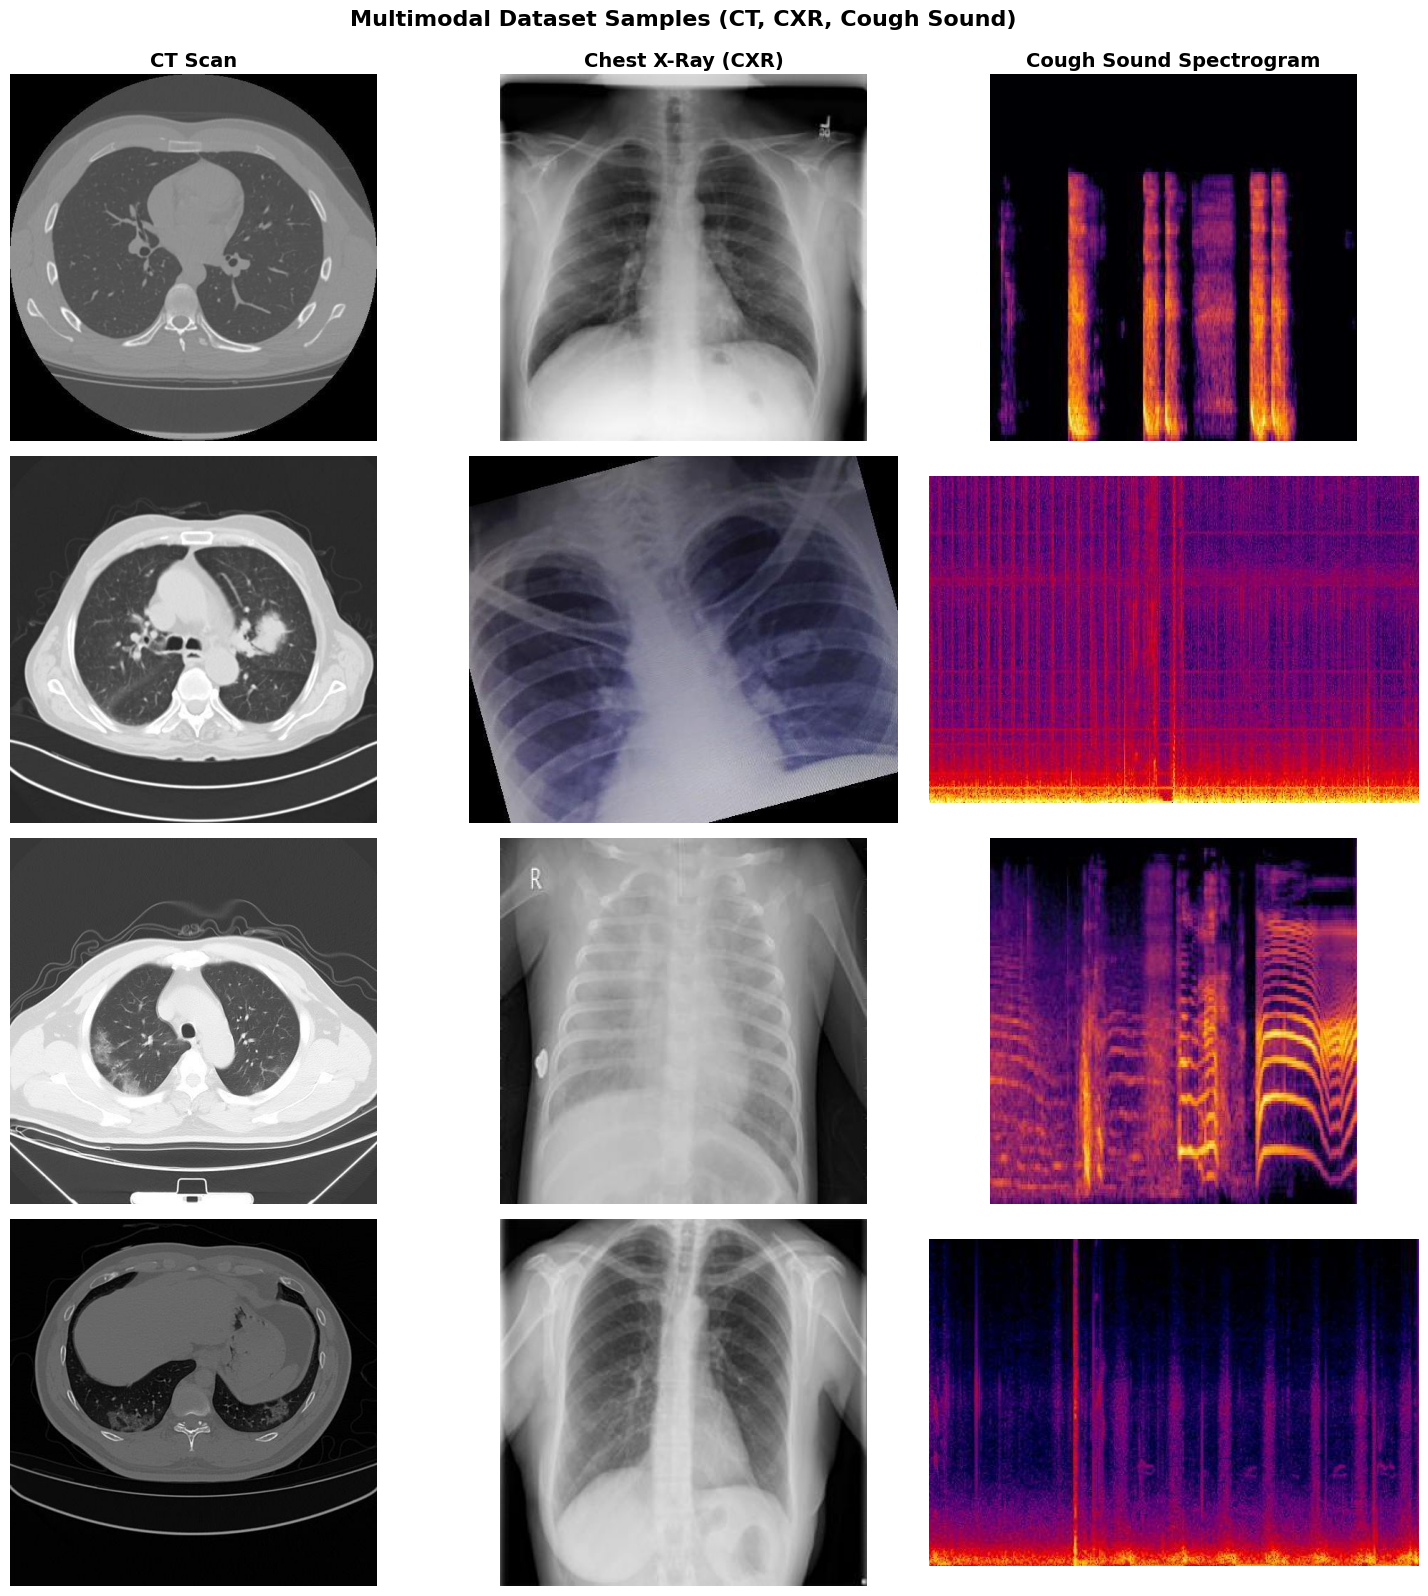

 Saved: multimodal_samples.png


In [5]:
# DATA VISUALIZATION
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random

print("="*60)
print(" VISUALIZING MULTIMODAL DATASET SAMPLES")
print("="*60)

# 1. Visualize Random Samples from Each Class

def visualize_multimodal_samples(num_samples=2):
    """
    Visualize samples showing all three modalities for each class
    """
    fig, axes = plt.subplots(len(classes), 3, figsize=(15, 4*len(classes)))
    fig.suptitle('Multimodal Dataset Samples (CT, CXR, Cough Sound)', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    for class_idx, cls in enumerate(classes):
        # Randomly select a sample
        sample_num = random.randint(1, splits['train'])
        
        # Load images for this sample
        ct_path = os.path.join(output_root, 'train', 'CT', cls, f"{cls}{sample_num}.jpg")
        cxr_path = os.path.join(output_root, 'train', 'CXR', cls, f"{cls}{sample_num}.jpg")
        cough_path = os.path.join(output_root, 'train', 'Cough sound', cls, f"{cls}{sample_num}.jpg")
        
        # Display CT scan
        ct_img = Image.open(ct_path)
        axes[class_idx, 0].imshow(ct_img)
        axes[class_idx, 0].axis('off')
        if class_idx == 0:
            axes[class_idx, 0].set_title('CT Scan', fontsize=14, fontweight='bold')
        axes[class_idx, 0].set_ylabel(cls, fontsize=12, fontweight='bold', rotation=0, 
                                       ha='right', va='center')
        
        # Display CXR
        cxr_img = Image.open(cxr_path)
        axes[class_idx, 1].imshow(cxr_img)
        axes[class_idx, 1].axis('off')
        if class_idx == 0:
            axes[class_idx, 1].set_title('Chest X-Ray (CXR)', fontsize=14, fontweight='bold')
        
        # Display Cough Sound
        cough_img = Image.open(cough_path)
        axes[class_idx, 2].imshow(cough_img)
        axes[class_idx, 2].axis('off')
        if class_idx == 0:
            axes[class_idx, 2].set_title('Cough Sound Spectrogram', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('multimodal_samples.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(" Saved: multimodal_samples.png")

visualize_multimodal_samples()

In [6]:
def build_early_fusion_model():
    """
    Early Fusion: Concatenate all three images at input level (9 channels)
    Then pass through one VGG16 network
    """
    print(" Building Early Fusion Model...")
    
    # Three separate inputs
    ct_input = layers.Input(shape=(224, 224, 3), name='ct_input')
    cxr_input = layers.Input(shape=(224, 224, 3), name='cxr_input')
    cough_input = layers.Input(shape=(224, 224, 3), name='cough_input')
    
    # Concatenate at channel level (Early Fusion)
    concatenated = layers.Concatenate(axis=-1)([ct_input, cxr_input, cough_input])
    # Shape: (224, 224, 9)
    
    # Reduce 9 channels to 3 using 1x1 convolution
    x = layers.Conv2D(3, (1, 1), activation='relu', name='channel_reducer')(concatenated)
    
    # VGG16 backbone (pre-trained on ImageNet)
    # Load VGG16 separately without input_tensor to avoid layer mismatch
    base_model = applications.VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    
    # Apply VGG16 to our preprocessed input
    x = base_model(x)
    
    # Freeze early layers, only train last few
    for layer in base_model.layers[:-4]:
        layer.trainable = False
    
    # Classification head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(4, activation='softmax', name='output')(x)
    
    model = keras.Model(
        inputs=[ct_input, cxr_input, cough_input],
        outputs=outputs,
        name='early_fusion_model'
    )
    
    return model


In [7]:
# Build Early Fusion Model
early_fusion_model = build_early_fusion_model()
early_fusion_model.summary()

 Building Early Fusion Model...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "early_fusion_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ct_input            │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cxr_input           │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cough_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 224, 224,  │          0 │ ct_input[0][0],   │
│ (Concatenate)       │ 9)                │            │ cxr_input[0][0],  │
│                     │                   │            │ cough_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ channel_reducer     │ (None, 224, 224,  │         30 │ concatenate[0][0] │
│ (Conv2D)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ channel_reducer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    262,656 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 4)         │      1,028 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,112,802 (57.65 MB)

 Trainable params: 7,476,002 (28.52 MB)

 Non-trainable params: 7,636,800 (29.13 MB)

In [8]:
# Compile
early_fusion_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

In [10]:
print("-" * 60)
print(" TRAINING EARLY FUSION MODEL")
print("-" * 60)

history_early = early_fusion_model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1
)

------------------------------------------------------------
 TRAINING EARLY FUSION MODEL
------------------------------------------------------------
Epoch 1/50


I0000 00:00:1760138235.593597      56 service.cc:148] XLA service 0x7818ac089080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760138235.594535      56 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1760138236.201854      56 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/100 ━━━━━━━━━━━━━━━━━━━━ 28:08 17s/step - accuracy: 0.1875 - loss: 2.1242

I0000 00:00:1760138246.024718      56 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.6854 - loss: 0.8746
Epoch 1: val_accuracy improved from -inf to 0.42000, saving model to best_model.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 181ms/step - accuracy: 0.6860 - loss: 0.8728 - val_accuracy: 0.4200 - val_loss: 1.0250 - learning_rate: 1.0000e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8543 - loss: 0.4163
Epoch 2: val_accuracy improved from 0.42000 to 0.51500, saving model to best_model.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - accuracy: 0.8542 - loss: 0.4164 - val_accuracy: 0.5150 - val_loss: 1.0956 - learning_rate: 1.0000e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8903 - loss: 0.3124
Epoch 3: val_accuracy improved from 0.51500 to 0.76000, saving model to best_model.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - accuracy: 0.8904 - loss: 0.3122 - val_accuracy: 0.7600 - val_loss: 0.5642 - learning_rate: 1.0000e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/ste

In [11]:
import seaborn as sns

In [12]:
def evaluate_model(model, test_dataset, model_name):
    """Evaluate model and show detailed results"""
    print(f"\n{'=' * 60}")
    print(f" EVALUATING {model_name}")
    print("=" * 60)
    
    # Get predictions
    y_true = []
    y_pred = []
    
    for (ct, cxr, cough), labels in test_dataset:
        predictions = model.predict([ct, cxr, cough], verbose=0)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(np.argmax(labels.numpy(), axis=1))
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate metrics
    test_loss, test_acc = model.evaluate(test_dataset, verbose=0)
    
    print(f"\n Test Accuracy: {test_acc:.4f}")
    print(f" Test Loss: {test_loss:.4f}")
    
    # Classification Report
    print("\n Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'{model_name}_confusion_matrix.png')
    plt.show()
    
    return test_acc, test_loss


 EVALUATING Early Fusion

 Test Accuracy: 0.9750
 Test Loss: 0.0547

 Classification Report:
              precision    recall  f1-score   support

     Healthy       0.94      0.98      0.96        50
 LungsCancer       0.98      1.00      0.99        50
   Pneumonia       1.00      1.00      1.00        50
       covid       0.98      0.92      0.95        50

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200



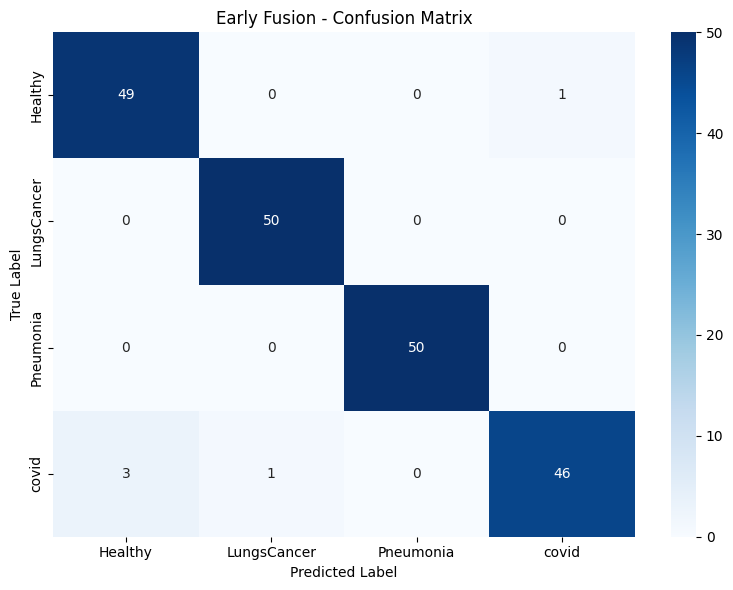

In [13]:
# Evaluate both models
early_acc, early_loss = evaluate_model(early_fusion_model, test_dataset, "Early Fusion")

In [14]:
# ==========================================
#  Plot Training Curves (Accuracy & Loss)
# ==========================================
import matplotlib.pyplot as plt

def plot_training_curves(history, model_name="Model"):
    """Plot training and validation accuracy/loss curves"""
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    
    epochs = range(1, len(acc) + 1)

    # --- Accuracy Plot ---
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, acc, 'o-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'o-', label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{model_name}_accuracy_curve.png')
    plt.show()

    # --- Loss Plot ---
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, loss, 'o-', label='Training Loss')
    plt.plot(epochs, val_loss, 'o-', label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{model_name}_loss_curve.png')
    plt.show()

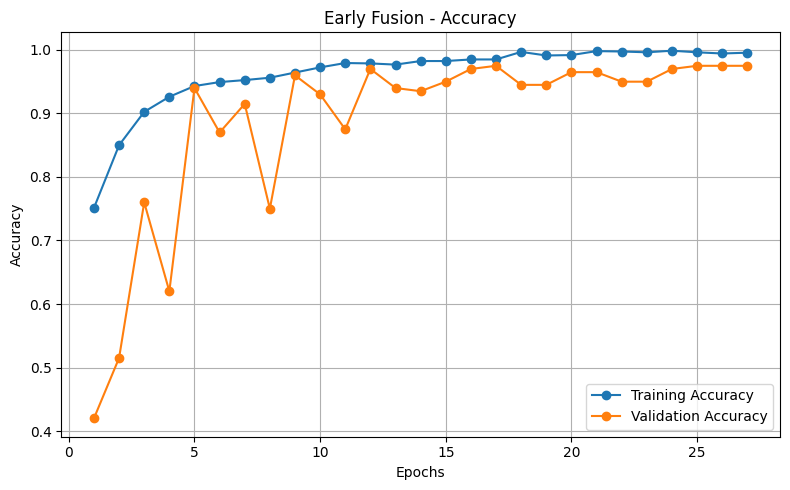

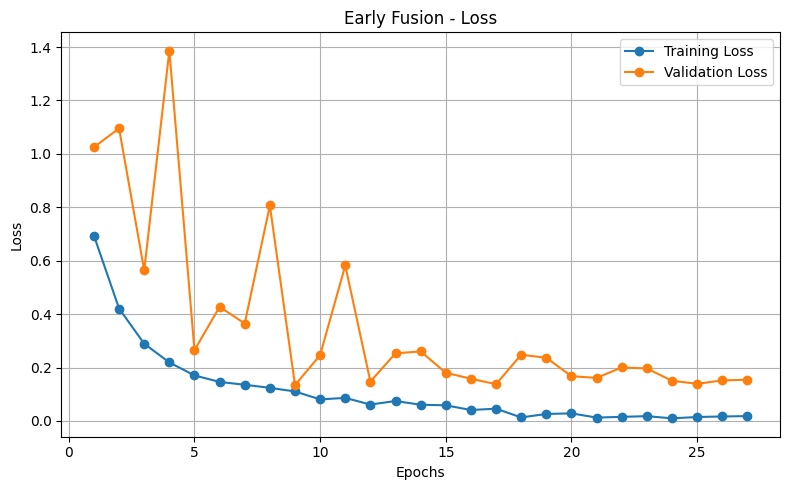

In [15]:
#  Call it here
plot_training_curves(history_early, "Early Fusion")

In [16]:
# 7. Save the final model
early_fusion_model.save('final_early_fusion_model.h5')
print(" Model saved as 'final_early_fusion_model.h5'")
print("\n Pipeline completed successfully!")

 Model saved as 'final_early_fusion_model.h5'

 Pipeline completed successfully!


In [17]:
def build_intermediate_fusion_model():
    """
    Intermediate Fusion: Extract features from each modality separately,
    then concatenate feature vectors before classification.
    Uses ResNet50 as the backbone (different from Early Fusion's VGG16)
    """
    print(" Building Intermediate Fusion Model...")
    
    # Three separate inputs
    ct_input = layers.Input(shape=(224, 224, 3), name='ct_input')
    cxr_input = layers.Input(shape=(224, 224, 3), name='cxr_input')
    cough_input = layers.Input(shape=(224, 224, 3), name='cough_input')
    
    # Shared ResNet50 backbone for feature extraction
    # Using include_top=False to get feature vectors
    base_model = applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    
    # Freeze early layers, train last few
    for layer in base_model.layers[:-10]:
        layer.trainable = False
    
    # Extract features from each modality separately
    ct_features = base_model(ct_input)
    cxr_features = base_model(cxr_input)
    cough_features = base_model(cough_input)
    
    # Global pooling for each modality
    ct_pooled = layers.GlobalAveragePooling2D(name='ct_pool')(ct_features)
    cxr_pooled = layers.GlobalAveragePooling2D(name='cxr_pool')(cxr_features)
    cough_pooled = layers.GlobalAveragePooling2D(name='cough_pool')(cough_features)
    
    # Intermediate Fusion: Concatenate feature vectors
    fused = layers.Concatenate(name='fusion_concat')([ct_pooled, cxr_pooled, cough_pooled])
    # Shape: (batch, 2048*3 = 6144)
    
    # Classification head
    x = layers.Dense(1024, activation='relu', name='fc1')(fused)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu', name='fc2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='relu', name='fc3')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(4, activation='softmax', name='output')(x)
    
    model = keras.Model(
        inputs=[ct_input, cxr_input, cough_input],
        outputs=outputs,
        name='intermediate_fusion_model'
    )
    
    return model

In [18]:
# Build and compile Intermediate Fusion Model
print("\n" + "-"*60)
print("  INTERMEDIATE FUSION MODEL (ResNet50)")
print("-"*60)

intermediate_fusion_model = build_intermediate_fusion_model()
intermediate_fusion_model.summary()


------------------------------------------------------------
  INTERMEDIATE FUSION MODEL (ResNet50)
------------------------------------------------------------
 Building Intermediate Fusion Model...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "intermediate_fusion_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ct_input            │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cxr_input           │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cough_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ ct_input[0][0],   │
│ (Functional)        │ 2048)             │            │ cxr_input[0][0],  │
│                     │                   │            │ cough_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ct_pool             │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cxr_pool            │ (None, 2048)      │          0 │ resnet50[1][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cough_pool          │ (None, 2048)      │          0 │ resnet50[2][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_concat       │ (None, 6144)      │          0 │ ct_pool[0][0],    │
│ (Concatenate)       │                   │            │ cxr_pool[0][0],   │
│                     │                   │            │ cough_pool[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc1 (Dense)         │ (None, 1024)      │  6,292,480 │ fusion_concat[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024)      │      4,096 │ fc1[0][0]         │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1024)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc2 (Dense)         │ (None, 512)       │    524,800 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ fc2[0][0]         │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc3 (Dense)         │ (None, 256)       │    131,328 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ fc3[0][0]         │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 4)         │      1,028 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 30,544,516 (116.52 MB)

 Trainable params: 11,418,884 (43.56 MB)

 Non-trainable params: 19,125,632 (72.96 MB)

In [19]:
# Compile
intermediate_fusion_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
# Train Intermediate Fusion Model
print("\n" + "-"*60)
print(" TRAINING INTERMEDIATE FUSION MODEL")
print("-"*60)

history_inter = intermediate_fusion_model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1
)


------------------------------------------------------------
 TRAINING INTERMEDIATE FUSION MODEL
------------------------------------------------------------
Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6761 - loss: 0.8628
Epoch 1: val_accuracy did not improve from 0.97500
100/100 ━━━━━━━━━━━━━━━━━━━━ 67s 239ms/step - accuracy: 0.6766 - loss: 0.8615 - val_accuracy: 0.2600 - val_loss: 1.2770 - learning_rate: 1.0000e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8169 - loss: 0.5298
Epoch 2: val_accuracy did not improve from 0.97500
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - accuracy: 0.8169 - loss: 0.5297 - val_accuracy: 0.7300 - val_loss: 0.9286 - learning_rate: 1.0000e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8200 - loss: 0.5201
Epoch 3: val_accuracy did not improve from 0.97500
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - accuracy: 0.8201 - loss: 0.5196 - val_accuracy: 0.7500 - val_loss: 0.6753 - learning_ra


 EVALUATING Intermediate Fusion

 Test Accuracy: 0.9800
 Test Loss: 0.0738

 Classification Report:
              precision    recall  f1-score   support

     Healthy       0.96      0.96      0.96        50
 LungsCancer       1.00      1.00      1.00        50
   Pneumonia       1.00      1.00      1.00        50
       covid       0.96      0.96      0.96        50

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200



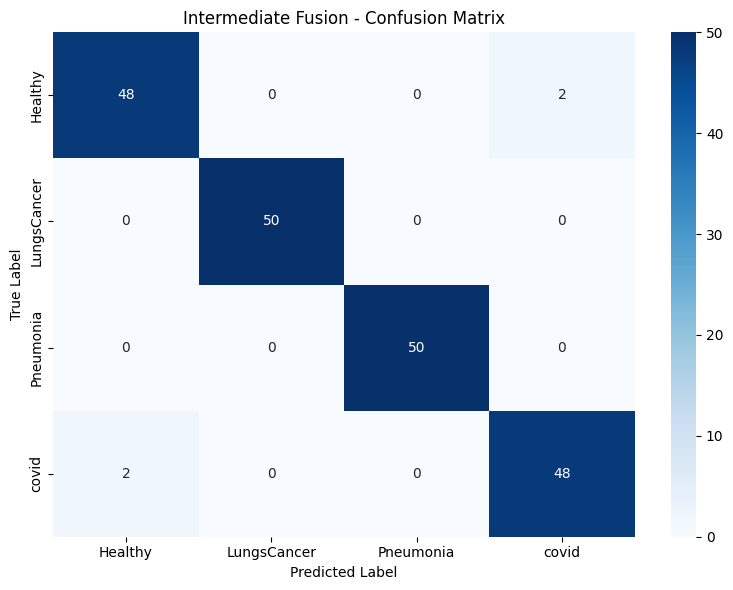

In [21]:
# Evaluate Intermediate Fusion Model
inter_acc, inter_loss = evaluate_model(
    intermediate_fusion_model, 
    test_dataset, 
    "Intermediate Fusion"
)

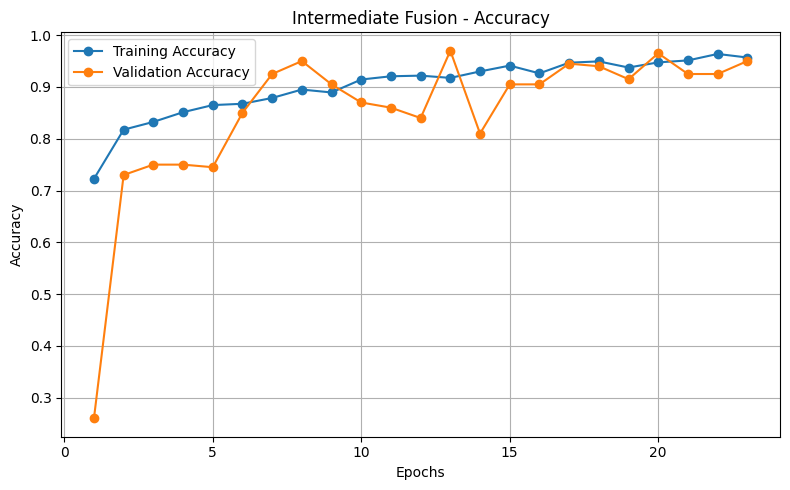

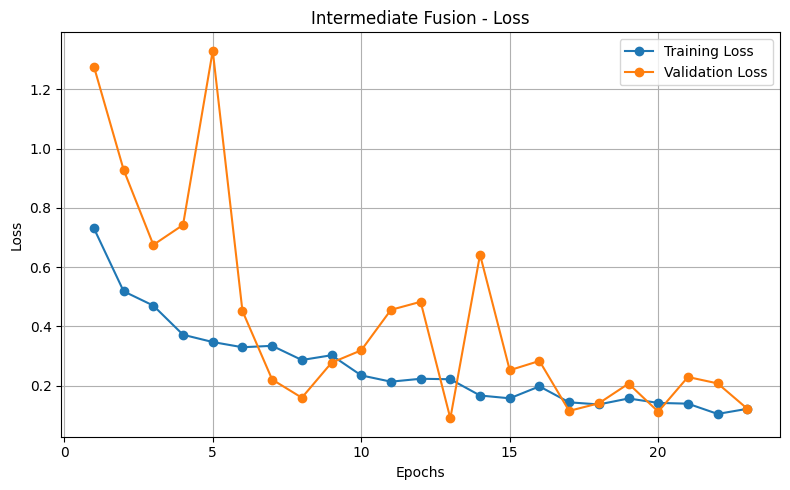

In [22]:
# Evaluate both models
plot_training_curves(history_inter, "Intermediate Fusion")

In [23]:
# Save Intermediate Fusion Model
intermediate_fusion_model.save('final_intermediate_fusion_model.h5')
print(" Model saved as 'final_intermediate_fusion_model.h5'")

 Model saved as 'final_intermediate_fusion_model.h5'


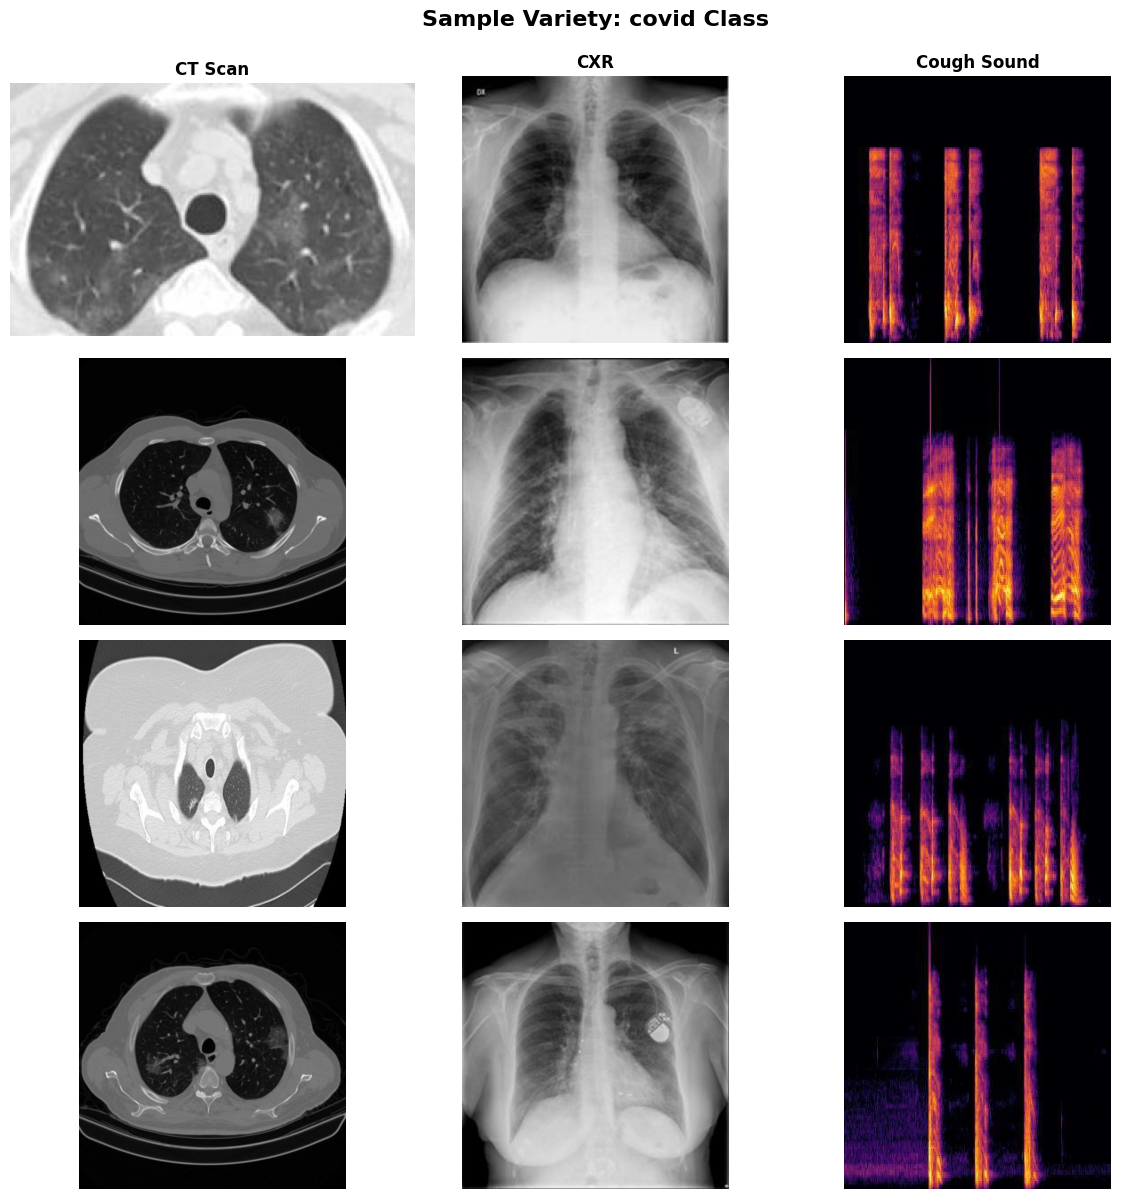

✅ Saved: covid_variety.png


In [24]:
def visualize_class_variety(class_name='covid', num_samples=6):
    """
    Show variety within a single class across all modalities
    """
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 3*num_samples))
    fig.suptitle(f'Sample Variety: {class_name} Class', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    # Randomly select samples
    sample_nums = random.sample(range(1, splits['train']), num_samples)
    
    for idx, sample_num in enumerate(sample_nums):
        # Load images
        ct_path = os.path.join(output_root, 'train', 'CT', class_name, 
                               f"{class_name}{sample_num}.jpg")
        cxr_path = os.path.join(output_root, 'train', 'CXR', class_name, 
                                f"{class_name}{sample_num}.jpg")
        cough_path = os.path.join(output_root, 'train', 'Cough sound', class_name, 
                                  f"{class_name}{sample_num}.jpg")
        
        # Display
        ct_img = Image.open(ct_path)
        axes[idx, 0].imshow(ct_img)
        axes[idx, 0].axis('off')
        if idx == 0:
            axes[idx, 0].set_title('CT Scan', fontsize=12, fontweight='bold')
        axes[idx, 0].set_ylabel(f'Sample {idx+1}', fontsize=10, rotation=0, 
                                ha='right', va='center')
        
        cxr_img = Image.open(cxr_path)
        axes[idx, 1].imshow(cxr_img)
        axes[idx, 1].axis('off')
        if idx == 0:
            axes[idx, 1].set_title('CXR', fontsize=12, fontweight='bold')
        
        cough_img = Image.open(cough_path)
        axes[idx, 2].imshow(cough_img)
        axes[idx, 2].axis('off')
        if idx == 0:
            axes[idx, 2].set_title('Cough Sound', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f'{class_name}_variety.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Saved: {class_name}_variety.png")

# Visualize variety for COVID class
visualize_class_variety('covid', num_samples=4)

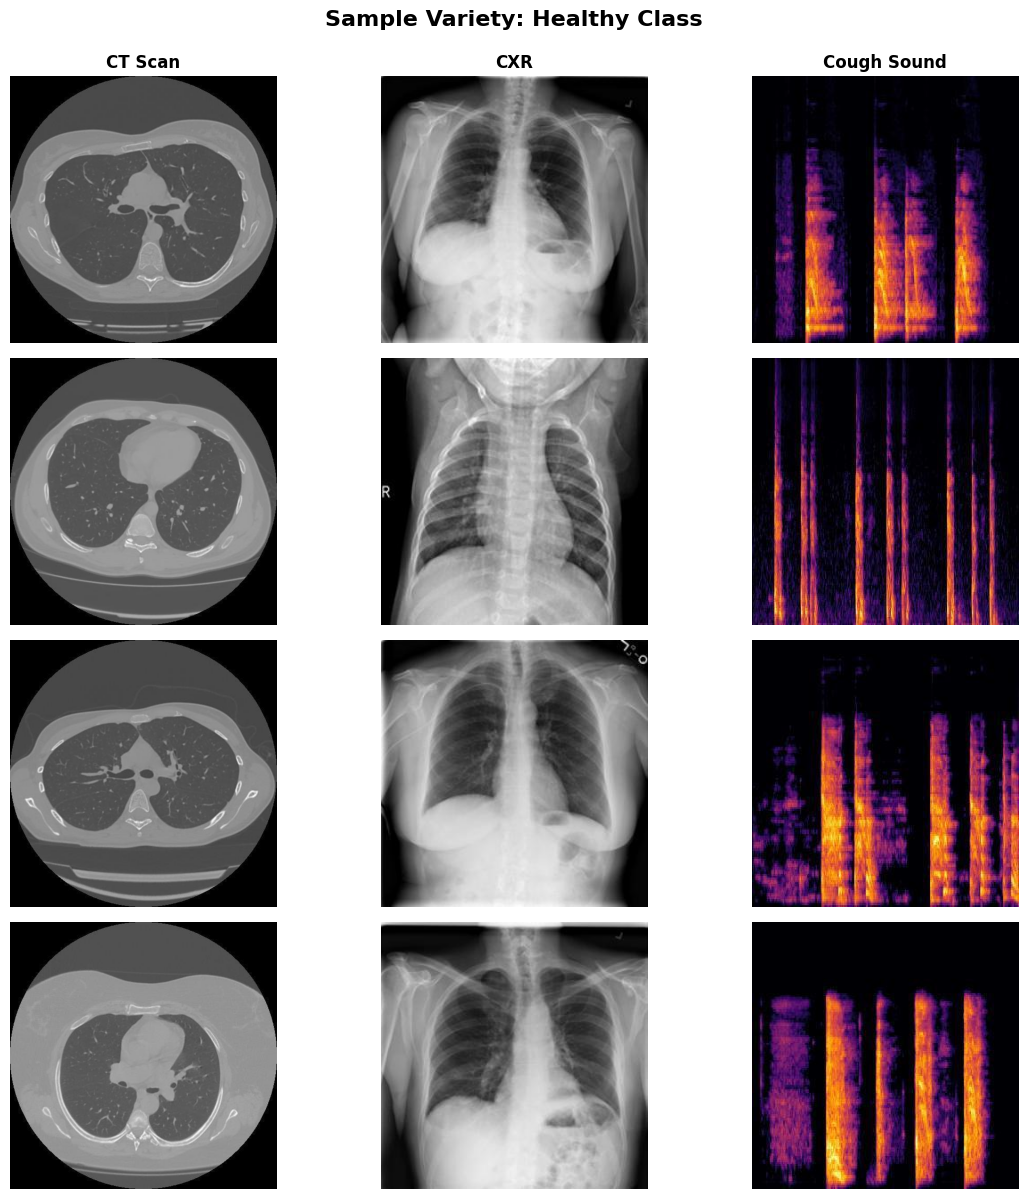

✅ Saved: Healthy_variety.png


In [25]:
# Visualize variety for Healthy class
visualize_class_variety('Healthy', num_samples=4)

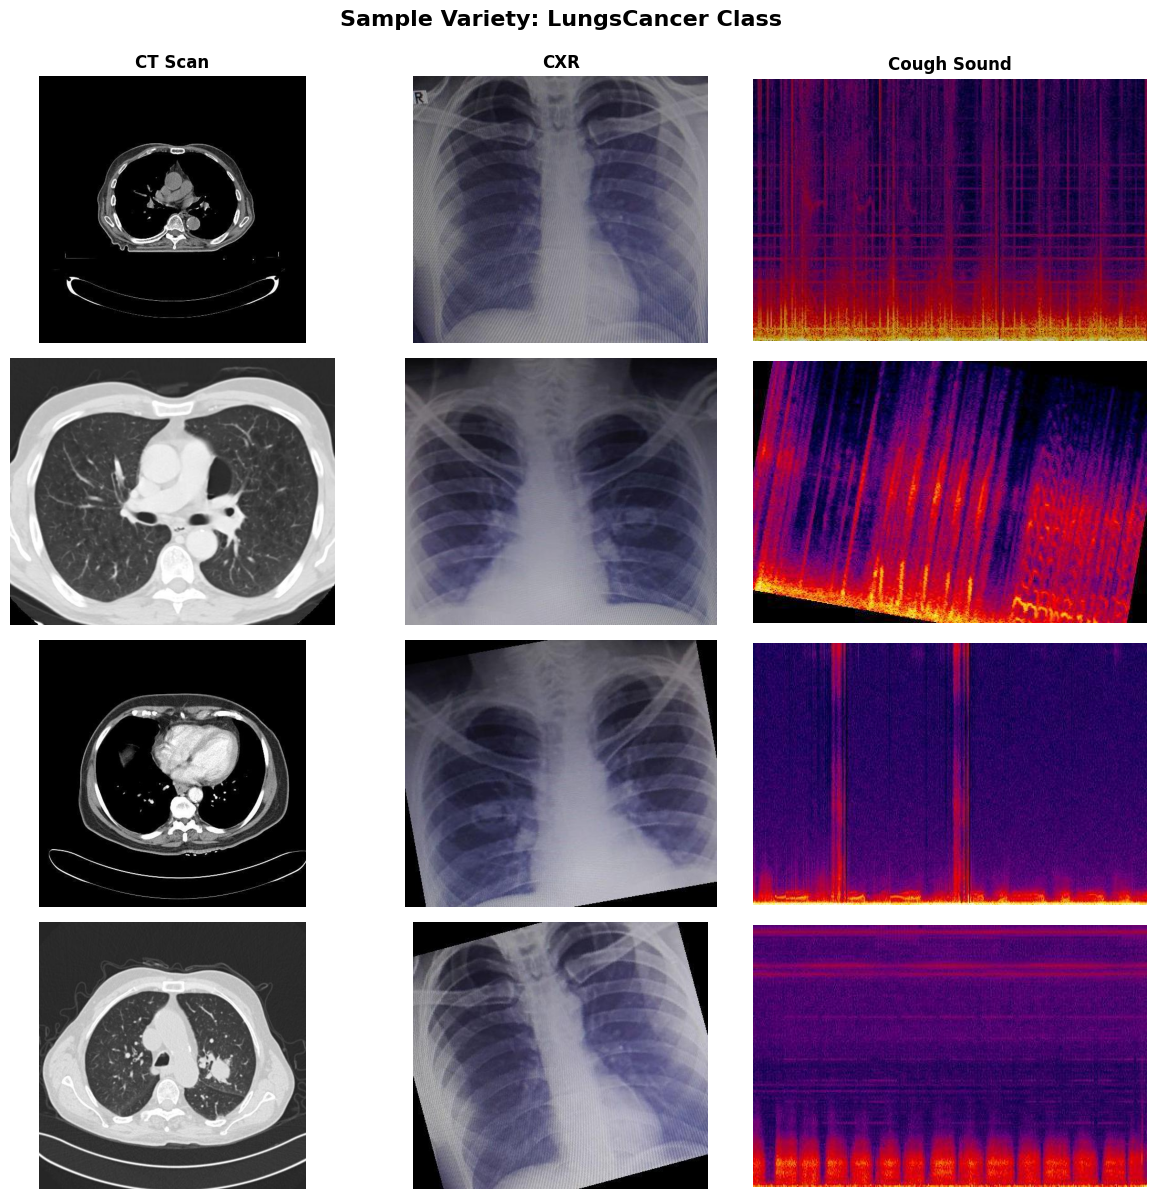

✅ Saved: LungsCancer_variety.png


In [26]:
# Visualize variety for LungsCancer class
visualize_class_variety('LungsCancer', num_samples=4)

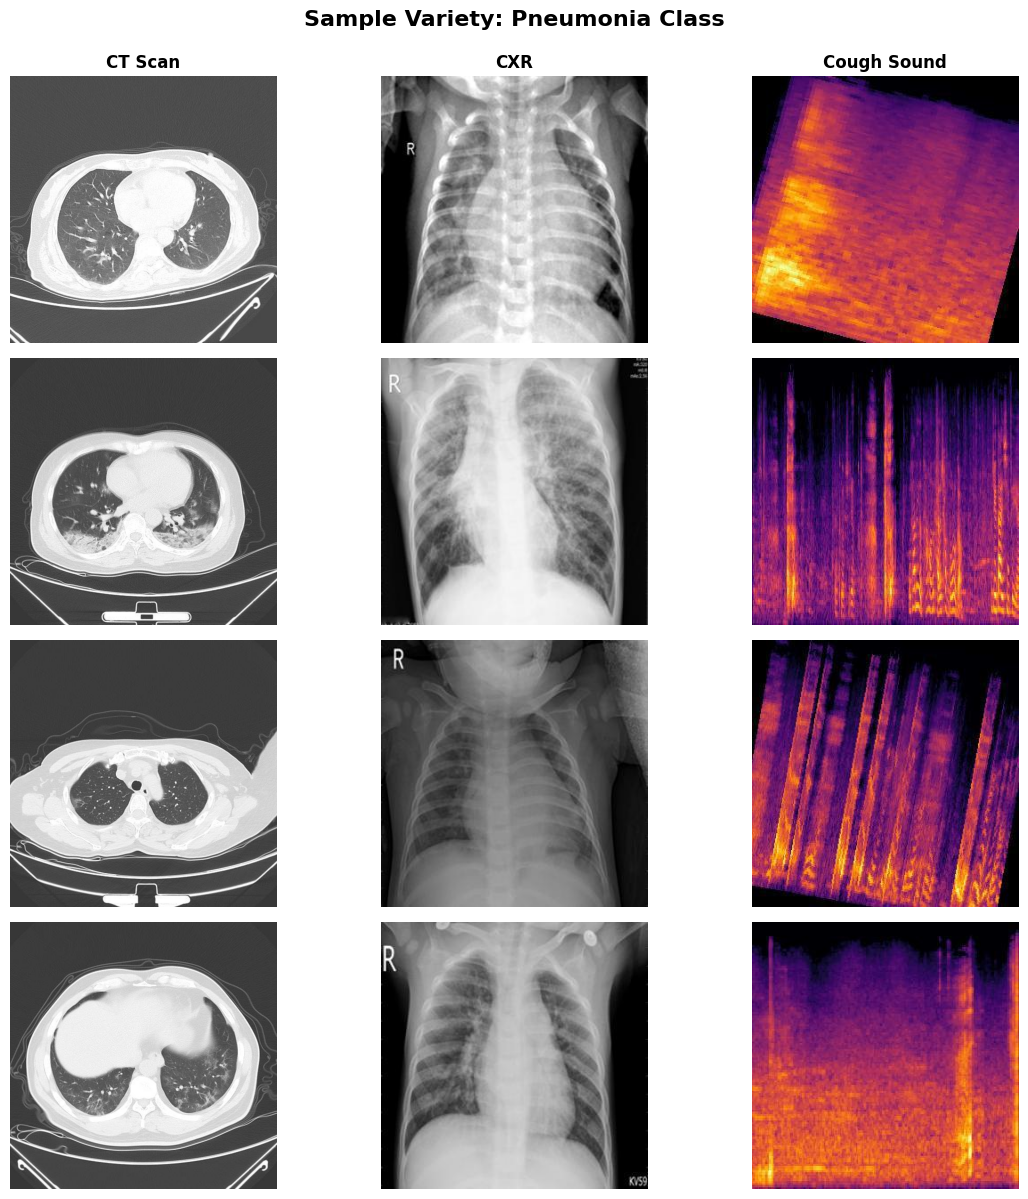

✅ Saved: Pneumonia_variety.png


In [27]:
# Visualize variety for Pneumonia class
visualize_class_variety('Pneumonia', num_samples=4)


📊 MODEL COMPARISON
                         Model Test Accuracy Test Loss
          Early Fusion (VGG16)        0.9750    0.0547
Intermediate Fusion (ResNet50)        0.9800    0.0738


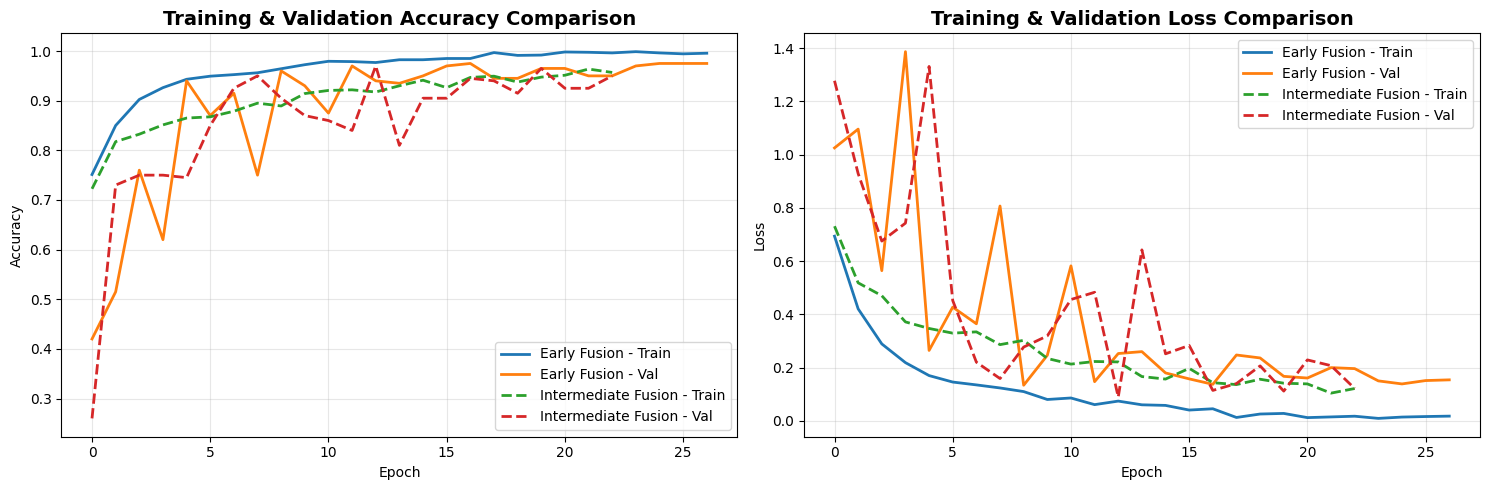


 Pipeline completed successfully!
 Comparison plot saved as 'model_comparison.png'


In [28]:
# Compare Both Models

print("\n" + "="*60)
print("📊 MODEL COMPARISON")
print("="*60)

comparison_data = {
    'Model': ['Early Fusion (VGG16)', 'Intermediate Fusion (ResNet50)'],
    'Test Accuracy': [f'{early_acc:.4f}', f'{inter_acc:.4f}'],
    'Test Loss': [f'{early_loss:.4f}', f'{inter_loss:.4f}']
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Visualize training history comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy comparison
axes[0].plot(history_early.history['accuracy'], label='Early Fusion - Train', linewidth=2)
axes[0].plot(history_early.history['val_accuracy'], label='Early Fusion - Val', linewidth=2)
axes[0].plot(history_inter.history['accuracy'], label='Intermediate Fusion - Train', 
             linewidth=2, linestyle='--')
axes[0].plot(history_inter.history['val_accuracy'], label='Intermediate Fusion - Val', 
             linewidth=2, linestyle='--')
axes[0].set_title('Training & Validation Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss comparison
axes[1].plot(history_early.history['loss'], label='Early Fusion - Train', linewidth=2)
axes[1].plot(history_early.history['val_loss'], label='Early Fusion - Val', linewidth=2)
axes[1].plot(history_inter.history['loss'], label='Intermediate Fusion - Train', 
             linewidth=2, linestyle='--')
axes[1].plot(history_inter.history['val_loss'], label='Intermediate Fusion - Val', 
             linewidth=2, linestyle='--')
axes[1].set_title('Training & Validation Loss Comparison', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n Pipeline completed successfully!")
print(" Comparison plot saved as 'model_comparison.png'")